In [4]:
import requests
import urllib3
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import matplotlib.pyplot as plt
import json
import glob
from datetime import datetime

# Oauth Strava

In [2]:
with open('../credentials.json') as f:
    credentials = json.load(f)

In [3]:
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

auth_url = "https://www.strava.com/oauth/token"
activites_url = "https://www.strava.com/api/v3/athlete/activities"

payload = {
    'client_id': credentials['client_id'],
    'client_secret': credentials['client_secret'],
    'refresh_token': credentials['refresh_token'],
    'grant_type': "refresh_token",
    'f': 'json'
}

print("Requesting Token...\n")
res = requests.post(auth_url, data=payload, verify=False)
access_token = res.json()['access_token']
print("Access Token = {}\n".format(access_token))

header = {'Authorization': 'Bearer ' + access_token}
param = {'per_page': 200, 'page': 1}
dataset = requests.get(activites_url, headers=header, params=param).json()

Requesting Token...

Access Token = 78b7c7cffeadd04583865624820e329eb545ad7e



# All Activities Analysis

In [5]:
activities = json_normalize(dataset)
activities_clean = activities.dropna(inplace=False, subset=['average_watts', 'average_heartrate'])

/var/folders/c1/t3jl667j411f1m5w0w88hfj00000gn/T/ipykernel_94841/3057335248.py:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  activities = json_normalize(dataset)


In [8]:
activities.to_csv('../data/activities.csv')
activities_clean.to_csv('../data/activities_clean.csv')

In [9]:
activities.columns

Index(['resource_state', 'name', 'distance', 'moving_time', 'elapsed_time',
       'total_elevation_gain', 'type', 'id', 'external_id', 'upload_id',
       'start_date', 'start_date_local', 'timezone', 'utc_offset',
       'location_city', 'location_state', 'location_country',
       'achievement_count', 'kudos_count', 'comment_count', 'athlete_count',
       'photo_count', 'trainer', 'commute', 'manual', 'private', 'visibility',
       'flagged', 'gear_id', 'from_accepted_tag', 'upload_id_str',
       'start_latlng', 'end_latlng', 'start_latitude', 'start_longitude',
       'average_speed', 'max_speed', 'average_cadence', 'average_watts',
       'max_watts', 'weighted_average_watts', 'kilojoules', 'device_watts',
       'has_heartrate', 'average_heartrate', 'max_heartrate',
       'heartrate_opt_out', 'display_hide_heartrate_option', 'elev_high',
       'elev_low', 'pr_count', 'total_photo_count', 'has_kudoed',
       'suffer_score', 'athlete.id', 'athlete.resource_state', 'map.id',
 

Text(0.5, 0, 'Activity ID')

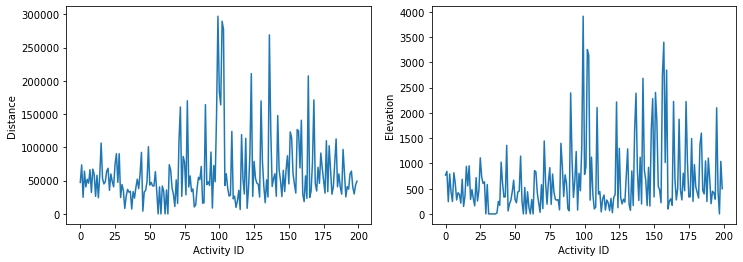

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
activities['distance'].plot(ax=ax1)
activities['total_elevation_gain'].plot(ax=ax2)
ax1.set_ylabel('Distance')
ax1.set_xlabel('Activity ID')
ax2.set_ylabel('Elevation')
ax2.set_xlabel('Activity ID')

<AxesSubplot:>

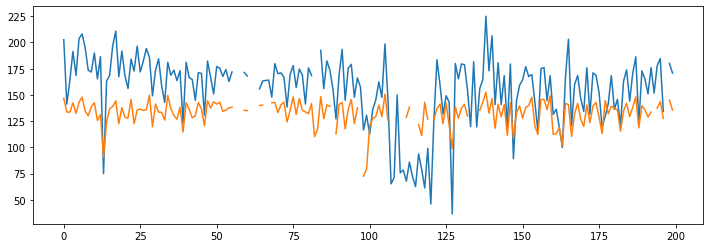

In [11]:
fig, ax = plt.subplots(figsize=(12,4))
activities['average_watts'].plot(ax=ax)
activities['average_heartrate'].plot(ax=ax)

### Average Watts Progression

In [12]:
df_watts = activities[['start_date_local', 'average_watts']].dropna(inplace=False)

In [13]:
m, b = np.polyfit(x=np.arange(len(df_watts)),
           y=df_watts['average_watts'],
           deg=1)
x = np.arange(len(df_watts))

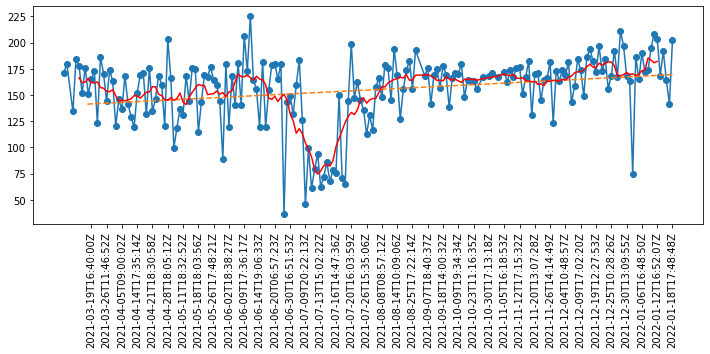

In [14]:
fig, ax = plt.subplots(figsize=(12,4))
df_watts['average_watts'].plot(ax=ax, marker='o')
ax.plot(x, m*x + b, ls='--')
df_watts['average_watts'].rolling(10, center=True).mean().plot(ax=ax, color='r')

ax.set_xticks(np.arange(0, len(df_watts), 5))
ax.set_xticklabels(df_watts['start_date_local'][np.arange(0, len(df_watts), 5)], rotation=90)
plt.gca().invert_xaxis()
plt.show()

# Classify Ride Type

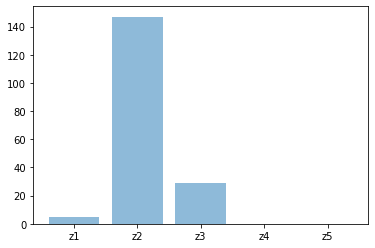

In [15]:
zones = [0, 108, 143, 161, 178, 200]


fig, ax = plt.subplots()
ax.bar(x = np.array([0, 1, 2, 3, 4]),
       height = np.histogram(activities['average_heartrate'], bins = zones)[0], 
       alpha=0.5)
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_xticklabels(['z1', 'z2', 'z3', 'z4', 'z5'])
plt.show()

In [16]:
def hr_zone(x):
    
    if 0 < x <= 108:
        zone = 'z1'
    elif 108 < x <= 143:
        zone = 'z2'
    elif 143 < x <= 161:
        zone = 'z3'
    elif 161 < x <= 178:
        zone = 'z4'
    elif 178 < x <= 200:
        zone = 'z5'
    else:
        return np.nan
        
    return zone

In [17]:
hr_zone = [hr_zone(x) for x in activities_clean['average_heartrate']]

In [18]:
df_hr = activities_clean[['start_date_local', 'average_heartrate']]
df_hr['hr_zone'] = hr_zone
df_hr

/var/folders/c1/t3jl667j411f1m5w0w88hfj00000gn/T/ipykernel_94841/2008091758.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hr['hr_zone'] = hr_zone


,start_date_local,average_heartrate,hr_zone
0,2022-01-18T17:48:48Z,146.8,z3
1,2022-01-16T10:04:59Z,133.7,z2
2,2022-01-16T08:11:59Z,133.5,z2
3,2022-01-15T14:44:58Z,142.4,z2
4,2022-01-13T18:24:18Z,132.4,z2
...,...,...,...
194,2021-03-14T10:50:35Z,137.4,z2
195,2021-03-13T07:20:11Z,143.6,z3
196,2021-03-12T17:18:04Z,127.7,z2
198,2021-03-10T16:42:19Z,145.0,z3


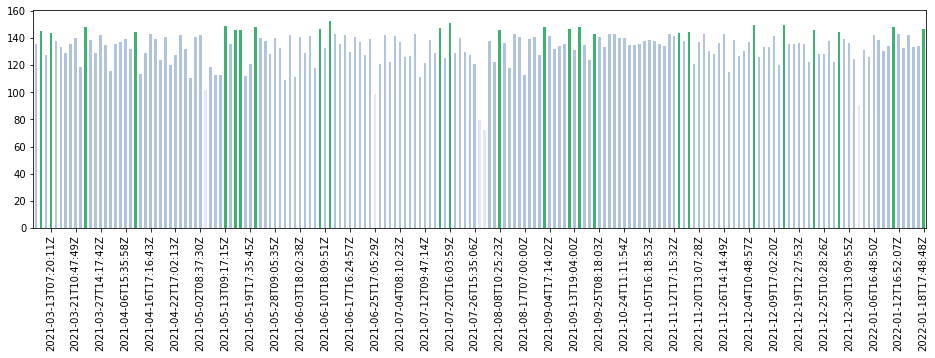

In [19]:
colors = {'z1': 'lavender', 'z2': 'lightsteelblue', 'z3': 'mediumseagreen', 'z4': 'coral', 'z5': 'firebrick'}

fig, ax = plt.subplots(figsize=(16,4))
df_hr['average_heartrate'].plot(kind='bar', ax=ax, color=list(df_hr['hr_zone'].map(colors)))

ax.set_xticks(np.arange(0, len(df_hr), 5))
ax.set_xticklabels(df_hr['start_date_local'].reset_index(drop=True)[np.arange(0, len(df_hr), 5)], rotation=90)
plt.gca().invert_xaxis()
plt.show()

# Classify Rider Type

# Cumulative Time Spent In Zone

- cumulative time in zone per ride (stacked barchart)
- cumulative time in zone for season (linechart)

- winter block, spring block, summer block, autumn block
- arbitrary training blocks
- yearly block

- heart rate time in zone
- pwr time in zone
- check for divergence -> training recommendations if divergence

### Save Data

In [ ]:
def get_activity(activity_id, access_token):
    
    # use the activity API to get activity data
    url = f'https://www.strava.com/api/v3/activities/{activity_id}?include_all_efforts=" "Authorization: Bearer {access_token}'
    res = requests.get(url, headers=header, params=param).json()

    return res

def get_activity_data_streams(activity_id, access_token):
    
    # use the streams api to get heartrate and watts data
    activity_url = f'https://www.strava.com/api/v3/activities/{activity_id}/streams?keys=watts,heartrate&key_by_type=" "Authorization: Bearer {access_token}'
    res = requests.get(activity_url, headers=header, params=param).json()
    
    return res

def save_activity_data(activity_id, activity_data, stream_data, path):
    
    # save activity data
    with open(f'{path}/activities/activity_{activity_id}.json', 'w', encoding='utf-8') as f:
        json.dump(activity_data, f, ensure_ascii=False, indent=4)
       
    # save stream data
    df = pd.DataFrame()
    df['heartrate'] = stream_data['heartrate']['data']
    df['watts'] = stream_data['watts']['data']
        
    df.to_csv(f'{path}/streams/stream_{activity_id}.csv', index=False)

In [ ]:
for activity_id in activities['id'][40:80]:
    
    try:
        activity_data = get_activity(activity_id, access_token)
        stream_data = get_activity_data_streams(activity_id, access_token)
        save_activity_data(activity_id, activity_data, stream_data, path='./data')
    except KeyError as e:
        continue

### Plot Cumulative Time In Zone for all Data

In [23]:
def cumulative_time_in_zone(start_date, end_date, chart_style='bar'):
    
    time_in_zone_hr = []
    time_in_zone_pwr = []
    start_date_local = []

    # set hr zones
    hr_zones = [0, 108, 143, 161, 178, 200]
    pwr_zones = [1, 163, 222, 267, 311, 356]

    # read all stream data
    for stream in glob.glob('../data/streams/*.csv'):

        activity_id = stream.split('_')[-1].split('.')[0]
        stream = pd.read_csv(stream)
        time_in_zone_hr.append(np.histogram(stream['heartrate'], bins = hr_zones)[0])
        time_in_zone_pwr.append(np.histogram(stream['watts'], bins = pwr_zones)[0])

        with open(f'../data/activities/activity_{activity_id}.json') as f:
            data = json.load(f)
        start_date_local.append(data['start_date_local'])

    # compute time_in_zone dataframe
    df_time_in_zone_hr = pd.DataFrame(np.vstack(time_in_zone_hr),
                                   columns=['z1', 'z2', 'z3', 'z4', 'z5'],
                                   index=start_date_local).sort_index()
    df_time_in_zone_pwr = pd.DataFrame(np.vstack(time_in_zone_pwr),
                                   columns=['z1', 'z2', 'z3', 'z4', 'z5'],
                                   index=start_date_local).sort_index()

    # set index as datetime
    df_time_in_zone_hr.index = pd.to_datetime(df_time_in_zone_hr.index)
    df_time_in_zone_pwr.index = pd.to_datetime(df_time_in_zone_pwr.index)

    # set mask for timeframe selection
    mask = (df_time_in_zone_hr.index > start_date) & (df_time_in_zone_hr.index <= end_date)
    mask = (df_time_in_zone_pwr.index > start_date) & (df_time_in_zone_pwr.index <= end_date)
    
    if chart_style == 'bar':
        
        # plot data
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        df_time_in_zone_hr[mask].sum().T.plot(kind='bar',
                               ax=ax1,
                               color=['lavender', 'lightsteelblue', 'mediumseagreen', 'coral', 'firebrick'])
        df_time_in_zone_pwr[mask].sum().T.plot(kind='bar',
                               ax=ax1,
                               color=['lavender', 'lightsteelblue', 'mediumseagreen', 'coral', 'firebrick'])
        ax1.set_ylabel('Time in Zone [sec]')
        ax1.set_xlabel(' ')
        ax1.set_title(f'{start_date.strftime("%d/%m/%Y")} to {end_date.strftime("%d/%m/%Y")}')

        df_time_in_zone_hr_pc = df_time_in_zone_hr[mask].sum()/df_time_in_zone_hr[mask].sum().sum()
        df_time_in_zone_pwr_pc = df_time_in_zone_pwr[mask].sum()/df_time_in_zone_pwr[mask].sum().sum()

        df_time_in_zone_hr_pc.T.plot(kind='bar',
                                  ax=ax2,
                                  color=['lavender', 'lightsteelblue', 'mediumseagreen', 'coral', 'firebrick'])
        df_time_in_zone_pwr_pc.T.plot(kind='bar',
                                  ax=ax2,
                                  color=['lavender', 'lightsteelblue', 'mediumseagreen', 'coral', 'firebrick'])
        ax2.set_ylabel('Time in Zone [%]')
        ax2.set_title(f'{start_date.strftime("%d/%m/%Y")} to {end_date.strftime("%d/%m/%Y")}')
        plt.show()
    
    elif chart_style == 'line':
        
        fig, ax = plt.subplots(figsize=(10,5))
        df_time_in_zone_hr.cumsum().plot(ax=ax,
                                      color=['lavender', 'lightsteelblue', 'mediumseagreen', 'coral', 'firebrick'])
        df_time_in_zone_pwr.cumsum().plot(ax=ax,
                                      color=['lavender', 'lightsteelblue', 'mediumseagreen', 'coral', 'firebrick'])
        ax.set_title(f'{start_date.strftime("%d/%m/%Y")} to {end_date.strftime("%d/%m/%Y")}')
        ax.set_ylabel('Time in Zone [sec]')
        plt.show()

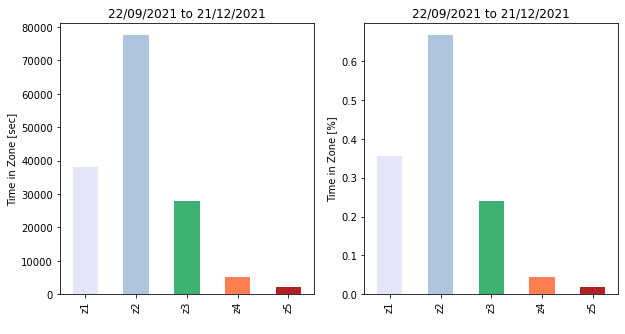

In [24]:
cumulative_time_in_zone(pd.to_datetime('22/09/2021', utc=True),
                        pd.to_datetime('21/12/2021', utc=True),
                        chart_style='bar')

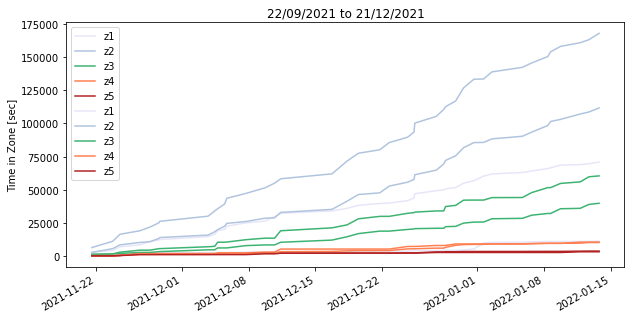

In [25]:
cumulative_time_in_zone(pd.to_datetime('22/09/2021', utc=True),
                        pd.to_datetime('21/12/2021', utc=True),
                        chart_style='line')

### Plot Cumulative Time In Zone for each Ride

In [26]:
def time_in_zone_per_ride(start_date, end_date):

    time_in_zone = []
    start_date_local = []
    
    # set hr zones
    zones = [0, 108, 143, 161, 178, 200]

    # read all stream data
    for stream in glob.glob('../data/streams/*.csv'):

        activity_id = stream.split('_')[-1].split('.')[0]
        stream = pd.read_csv(stream)
        time_in_zone.append(np.histogram(stream['heartrate'], bins = zones)[0])

        with open(f'../data/activities/activity_{activity_id}.json') as f:
            data = json.load(f)
        start_date_local.append(data['start_date_local'])

    # compute time_in_zone dataframe
    df_time_in_zone = pd.DataFrame(np.vstack(time_in_zone),
                                   columns=['z1', 'z2', 'z3', 'z4', 'z5'],
                                   index=start_date_local).sort_index()
    
    # set index as datetime
    df_time_in_zone.index = pd.to_datetime(df_time_in_zone.index)

    # set mask for timeframe selection
    mask = (df_time_in_zone.index > start_date) & (df_time_in_zone.index <= end_date)
    
    # plot data
    fig, ax = plt.subplots(figsize=(12,5))
    df_time_in_zone[mask].plot(kind='bar', ax=ax,
                         stacked=True,
                         color=['lavender', 'lightsteelblue', 'mediumseagreen', 'coral', 'firebrick'])

    ax.set_ylabel('Time in Zone [sec]')
    plt.legend(loc='upper right')
    plt.title(f'{start_date.strftime("%d/%m/%Y")} to {end_date.strftime("%d/%m/%Y")}')
    plt.show()

### Seasonal Training Blocks

In [27]:
# Winter 2021-2022
#timeframe = [pd.to_datetime('21/12/2021', utc=True), pd.to_datetime('20/03/2022', utc=True)]

# Spring 2022
#timeframe = [pd.to_datetime('20/03/2022', utc=True), pd.to_datetime('21/06/2022', utc=True)]

# Summer 2022
#timeframe = [pd.to_datetime('21/06/2022', utc=True), pd.to_datetime('23/09/2022', utc=True)]

# Autumn 2021
timeframe = [pd.to_datetime('22/09/2021', utc=True), pd.to_datetime('21/12/2021', utc=True)]

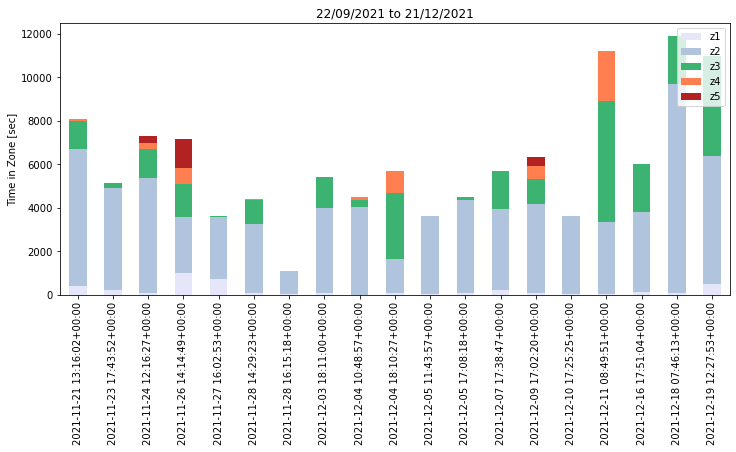

In [28]:
time_in_zone_per_ride(timeframe[0], timeframe[-1])

# Activity Analysis

In [29]:
activity_url = f'https://www.strava.com/api/v3/activities/6518486319?include_all_efforts=" "Authorization: Bearer {access_token}'
res = requests.get(activity_url, headers=header, params=param).json()

In [30]:
res

{'resource_state': 3,
 'athlete': {'id': 2374178, 'resource_state': 1},
 'name': 'Evening Ride',
 'distance': 40578.4,
 'moving_time': 5571,
 'elapsed_time': 5689,
 'total_elevation_gain': 429.0,
 'type': 'Ride',
 'workout_type': None,
 'id': 6518486319,
 'external_id': 'garmin_push_8112339278',
 'upload_id': 6931052250,
 'start_date': '2022-01-13T17:24:18Z',
 'start_date_local': '2022-01-13T18:24:18Z',
 'timezone': '(GMT+01:00) Europe/Zurich',
 'utc_offset': 3600.0,
 'location_city': None,
 'location_state': None,
 'location_country': 'Suisse',
 'achievement_count': 3,
 'kudos_count': 10,
 'comment_count': 0,
 'athlete_count': 1,
 'photo_count': 0,
 'map': {'id': 'a6518486319',
  'polyline': 'yi~xGk|kd@H\\NTNHFLv@ZV@nBZ`EbA^NhAVhANTHd@Dz@Vl@Jb@LXPVRb@l@Rb@hAtFBZI^?FZd@JXfAlA^Zt@x@TVf@~@ZXJVj@|@PPh@`@H\\~@~A^j@TD`@h@bDhFTX^b@Xd@f@p@Vh@Rl@PbAVdA^hA|@lDn@lB~AbHJvARhACAVX`@xANx@Pl@Hl@vBlJn@xCZlAZ`BTp@Tv@pArGl@|BjApFZfARbA`@tA@^^vAGl@@Nj@tCx@pCt@`Bn@bBVNLNT\\DLD^AXWj@AH@TVnAp@bCf@pBX|@Fb@K

In [33]:
res.keys()

dict_keys(['watts', 'distance', 'heartrate'])

In [32]:
activity_url = f'https://www.strava.com/api/v3/activities/6518486319/streams?keys=watts,heartrate&key_by_type=" "Authorization: Bearer {access_token}'
res = requests.get(activity_url, headers=header, params=param).json()

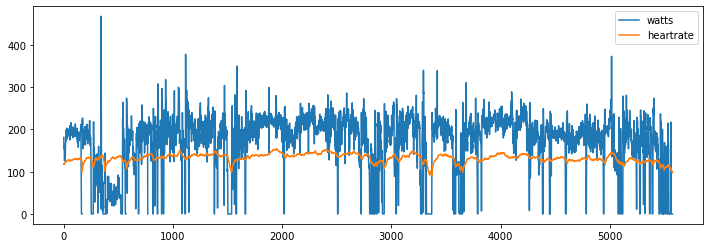

In [34]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(res['watts']['data'], label='watts')
ax.plot(res['heartrate']['data'], label='heartrate')
plt.legend()
plt.show()

In [35]:
zones = [0, 108, 143, 161, 178, 200]

In [36]:
np.histogram(res['heartrate']['data'], bins = zones)

(array([ 118, 4786,  672,    0,    0]), array([  0, 108, 143, 161, 178, 200]))

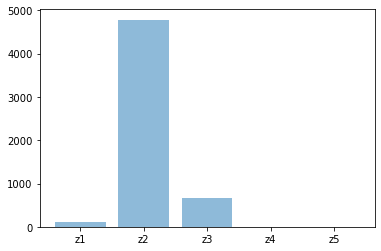

In [37]:
fig, ax = plt.subplots()
ax.bar(x = np.array([0, 1, 2, 3, 4]),
       height = np.histogram(res['heartrate']['data'], bins = zones)[0], 
       alpha=0.5)
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_xticklabels(['z1', 'z2', 'z3', 'z4', 'z5'])
plt.show()

- filter activities to bike rides
- clean data from NaN
- regression/trendline/smoothing of average watts/distance/speed over time for progression
- time in zones per year/month
- time in zones and effect on training (?)
- rider type classification (rouleur, puncheur, sprinter, climber, etc.)
- workouts based on rider type classification
- workouts to improve certain zones/characteristics
- is workload/training adapted ? (check fatigue/hr/pwr after big workouts/weeks)